In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/FinalPipeline')
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
matplotlib.style.use('des_dr1')
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
from os import listdir
import Config
import StellarConfig as strConfig
from GetObjects import *

# Classification Plot

In [2]:
stellarDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/FinalPipeline/Tests/ProbPlots/80/'

In [3]:
res = strConfig.res
gCut = strConfig.gCut
numMagBins = 1
magBins = [23.9, 24.5]
classCutoff = strConfig.classCutoff
binNum = strConfig.binNum

In [4]:
path = strConfig.path
mu = strConfig.mu

In [5]:
matBalrStarFile = Config.matBalrStarFile
detBalrStarFile = Config.detBalrStarFile

pixFile = strConfig.pixFile
condFiles = strConfig.condFiles

In [6]:
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

In [7]:
starDir = stellarDir + 'Stars/'
starProbFile = starDir + 'Star_Prob_Bin1.fits'
starDetAsStarProbFile = starDir + 'Star_Det_As_Star_Prob_Bin1.fits'
# starTrainFile = starDir + 'Star_Train_Bin1.fits'
# aveAcc = loadtxt(starTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',')

In [8]:
injDir = stellarDir + 'InjectionData/'
valIDDir = injDir + 'ValidPix/'
# valIDFile = valIDDir + 'Val_ID.fits'
# valID = fitsio.read(valIDFile)['ID']

In [9]:
# testIDFile = valIDDir + 'Test_ID.fits'

In [10]:
# starID = fitsio.read(detBalrStarFile, columns = ['bal_id'])['bal_id']

In [11]:
# testID = starID[~np.isin(starID, valID)]
# my_table = Table()
# my_table['ID'] = testID
# my_table.write(testIDFile, overwrite = True)

In [12]:
matStarFile = injDir + 'Test_Mat_Stars.fits'
detStarAllPosFile = injDir + 'Test_Det_Stars_All_Position_Data.fits'
# getMatStars(path, mu, res, matBalrStarFile, detBalrStarFile, pixFile, matStarFile, gCut, classCutoff, cutID = True, valIDFile = testIDFile)
# getDetStarPositions(res, detBalrStarFile, pixFile, detStarAllPosFile, cutID = True, valIDFile = testIDFile)

In [13]:
testData = fitsio.read(matStarFile)
testRa = testData['RA']
testDec = testData['DEC']
testPixRepeats = hp.ang2pix(res, testRa, testDec, lonlat = True, nest = True)
tempTestClass = testData['CLASS']
testClass = np.zeros(len(tempTestClass))
testClass[np.where(tempTestClass <= classCutoff)[0]] = 1
testRmag = testData['RMAG']

In [14]:
magCut = np.where((testRmag > magBins[0]) & (testRmag <= magBins[1]))[0]
testPixRepeats = testPixRepeats[magCut]
testClass = testClass[magCut]

In [15]:
pix, total = np.unique(testPixRepeats, return_counts = True)
_, orig = np.unique(np.append(pix, testPixRepeats[np.where(testClass == 1)[0]]), return_counts = True)
orig = orig - 1

In the above, pix represents pixel values, total the total number of observed stars, and orig the number of correctly classified stars.

In [16]:
starCorrProb = fitsio.read(starProbFile)['SIGNAL'] # This is relative

In [17]:
fullSkyProb = np.zeros(12*(res**2))
fullSkyProb[validPix] = starCorrProb
testCorrection = fullSkyProb[pix]

In [18]:
corr = orig / testCorrection

corr is now a corrected count.

In [19]:
condInd = 37
condData = fitsio.read(condFiles[condInd])['SIGNAL']
condMap = np.full(12*(res**2), hp.UNSEEN)
condMap[validPix] = condData

In [20]:
cutCondMap = condMap[pix]

In [21]:
sortInds = cutCondMap.argsort()

In [22]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((len(pix) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [23]:
condMapSort = cutCondMap[sortInds[::1]]
condBins = []
for j in range(binNum):
    condBins.append(condMapSort[binIndLims[j]:binIndLims[j+1]])
xBins = []

for j in range(binNum):
    xBins.append(np.sum(condBins[j]) / len(condBins[j]))
    
xBins = np.array(xBins)

In [24]:
corSort = orig[sortInds[::1]]
allSort = total[sortInds[::1]]

corBins = []
allBins = []
for j in range(binNum):
    corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
    allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

yBinsOrig = []

for j in range(binNum):
    yBinsOrig.append(np.sum(corBins[j]) / (np.sum(allBins[j])))
    
yBinsOrig = np.array(yBinsOrig)
yBinsOrig = yBinsOrig / np.average(yBinsOrig)

In [25]:
corSort = corr[sortInds[::1]]
allSort = total[sortInds[::1]]

corBins = []
allBins = []
for j in range(binNum):
    corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
    allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

yBinsCorr = []

for j in range(binNum):
    yBinsCorr.append(np.sum(corBins[j]) / (np.sum(allBins[j])))
    
yBinsCorr = np.array(yBinsCorr)
yBinsCorr = yBinsCorr / np.average(yBinsCorr)

Normalization is similar to calibration done on real data.

In [26]:
stdOrig = str(round(np.std(yBinsOrig), 3))
stdCorr = str(round(np.std(yBinsCorr), 3))

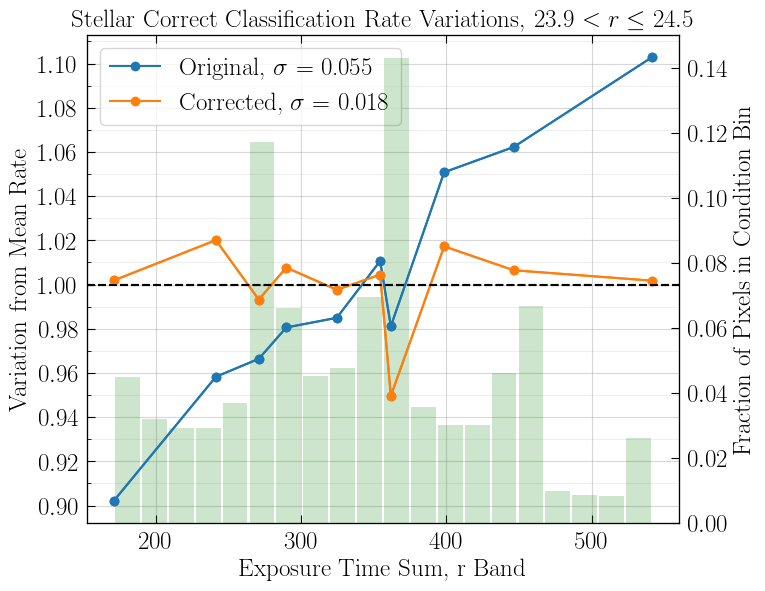

In [27]:
condition = Config.conditions[condInd]

fig, ax1 = plt.subplots()

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 2, 0.02)
minor_ticks = np.arange(0, 2, 0.01)

ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.set_xlabel(condition)
ax1.tick_params(axis='y')
ax1.set_ylabel(r'Variation from Mean Rate')
ax1.plot(xBins, yBinsOrig, marker = 'o', label = r'Original, $\sigma$ = ' + stdOrig)
ax1.plot(xBins, yBinsCorr, marker = 'o', label = r'Corrected, $\sigma$ = ' + stdCorr)
ax1.axhline(y = 1, color = 'black', linestyle = '--')
# And a corresponding grid
ax1.grid(which='both')

# Or if you want different settings for the grids:
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)
# ax1.grid()
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.tick_params(axis='y')
ax2.set_ylabel('Fraction of Pixels in Condition Bin')
ax2.hist(condData, bins = np.linspace(np.min(xBins), np.max(xBins), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condData)) / len(condData))

ax3 = ax1.twinx()
ax3.tick_params(axis='y', right = False, labelright = False)
ax3.plot(xBins, yBinsOrig, marker = 'o')
ax3.plot(xBins, yBinsCorr, marker = 'o')
ax3.axhline(y = 1, color = 'black', linestyle = '--')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(r'Stellar Correct Classification Rate Variations, $23.9<r\leq 24.5$')
plt.show()

# Relative Detection Rate

In [28]:
pix = np.unique(fitsio.read(detStarAllPosFile)['PIXEL'])
total = np.ones(len(pix))

In [29]:
_, orig = np.unique(np.append(pix, testPixRepeats[np.where(testClass == 1)[0]]), return_counts = True)
orig = orig - 1

In [30]:
starDetProb = fitsio.read(starDetAsStarProbFile)['SIGNAL']

In [31]:
fullSkyProb = np.zeros(12*(res**2))
fullSkyProb[validPix] = starDetProb
testCorrection = fullSkyProb[pix]

In [32]:
corr = orig / testCorrection

In [33]:
cutCondMap = condMap[pix]

In [34]:
sortInds = cutCondMap.argsort()

In [35]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((len(pix) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [36]:
condMapSort = cutCondMap[sortInds[::1]]
condBins = []
for j in range(binNum):
    condBins.append(condMapSort[binIndLims[j]:binIndLims[j+1]])
xBins = []

for j in range(binNum):
    xBins.append(np.sum(condBins[j]) / len(condBins[j]))
    
xBins = np.array(xBins)

In [37]:
corSort = orig[sortInds[::1]]
allSort = total[sortInds[::1]]

corBins = []
allBins = []
for j in range(binNum):
    corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
    allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

yBinsOrig = []

for j in range(binNum):
    yBinsOrig.append(np.sum(corBins[j]) / (np.sum(allBins[j])))
    
yBinsOrig = np.array(yBinsOrig)
yBinsOrig = yBinsOrig / np.average(yBinsOrig)

In [38]:
corSort = corr[sortInds[::1]]
allSort = total[sortInds[::1]]

corBins = []
allBins = []
for j in range(binNum):
    corBins.append(corSort[binIndLims[j]:binIndLims[j+1]])
    allBins.append(allSort[binIndLims[j]:binIndLims[j+1]])

yBinsCorr = []

for j in range(binNum):
    yBinsCorr.append(np.sum(corBins[j]) / (np.sum(allBins[j])))
    
yBinsCorr = np.array(yBinsCorr)
yBinsCorr = yBinsCorr / np.average(yBinsCorr)

In [39]:
stdOrig = str(round(np.std(yBinsOrig), 3))
stdCorr = str(round(np.std(yBinsCorr), 3))

In [40]:
print(stdOrig)
print(stdCorr)

0.145
0.029


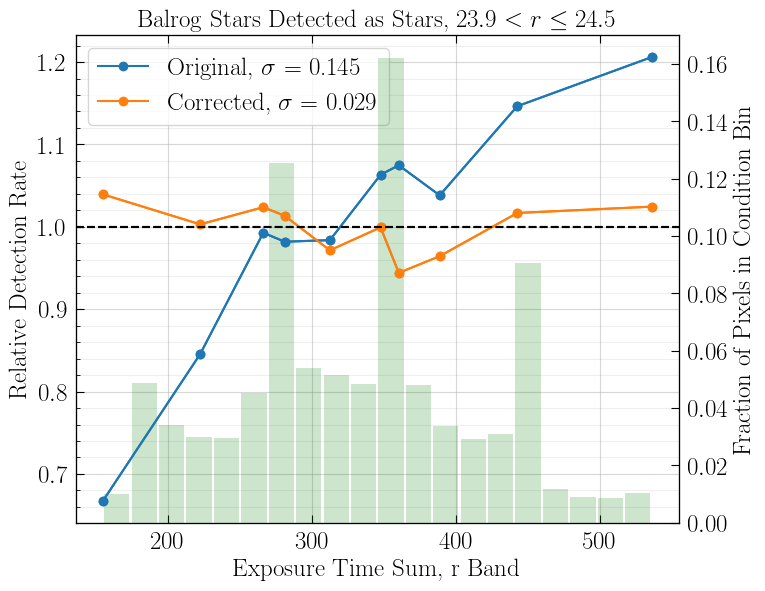

In [41]:
condition = Config.conditions[condInd]

fig, ax1 = plt.subplots()

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 2, 0.1)
minor_ticks = np.arange(0, 2, 0.02)

ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.set_xlabel(condition)
ax1.tick_params(axis='y')
ax1.set_ylabel(r'Relative Detection Rate')
ax1.plot(xBins, yBinsOrig, marker = 'o', label = r'Original, $\sigma$ = 0.145')
ax1.plot(xBins, yBinsCorr, marker = 'o', label = r'Corrected, $\sigma$ = 0.029')
ax1.axhline(y = 1, color = 'black', linestyle = '--')
# And a corresponding grid
ax1.grid(which='both')

# Or if you want different settings for the grids:
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)
# ax1.grid()
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.tick_params(axis='y')
ax2.set_ylabel('Fraction of Pixels in Condition Bin')
ax2.hist(condData, bins = np.linspace(np.min(xBins), np.max(xBins), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condData)) / len(condData))

ax3 = ax1.twinx()
ax3.tick_params(axis='y', right = False, labelright = False)
ax3.plot(xBins, yBinsOrig, marker = 'o')
ax3.plot(xBins, yBinsCorr, marker = 'o')
ax3.axhline(y = 1, color = 'black', linestyle = '--')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(r'Balrog Stars Detected as Stars, $23.9<r\leq 24.5$')
plt.show()